In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.tokenize import sent_tokenize, word_tokenize
# from nltk.tokenizer import tokenize
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import SMOTE
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [2]:
# read the dataset
reviews_data = pd.read_json(r"C:\Users\user\Documents\UoM\Thesis\data\Clothing_Shoes_and_Jewelry_5.json", lines=True)

# Keep only the review text and the grade
reviews_data = reviews_data[['overall', 'reviewText']]


# Drop the products whose values are null
reviews_data = reviews_data[reviews_data['reviewText'].notna()]

In [3]:
ratings = []
for index,entry in enumerate(reviews_data['overall']):
    if entry == 1.0 or entry == 2.0:
        ratings.append(-1)
    elif entry == 3.0:
        ratings.append(0)
    elif entry == 4.0 or entry == 5.0:
        ratings.append(1)

In [4]:
""""
Split each review into sentences
and preprocess each sentence
"""
stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.extend(['wear', 'shoe', 'size', 'fit', 'look', 'one', 'good'])

preprocessed_data = []
index = 0
for review in reviews_data['reviewText']:
    if ((index % 10000) == 0):
        print(str(round(((index/len(reviews_data)*100)), 2)) + "% of the total reviews have been preprocessed")   
    review_sentences = tokenizer.tokenize(review)
    for sentence in review_sentences:
        sentence = re.sub(r'not a *', 'not',sentence)
        sentence = re.sub(r'not *', 'not',sentence) 
        sentence = re.sub(r"\w+n't ", 'not',sentence) 
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        sentence = sentence.lower()
        sentence = word_tokenize(sentence)
        sentence = [word for word in sentence if not word in stopwords]
        sentence = ' '.join(sentence)
        if(sentence != ''):
            review = {}
            review["index"] = index
            review["sentence"] = sentence
            review["rating"] = ratings[index]
            preprocessed_data.append(review)
    index += 1
print("100% of the total reviews have been preprocessed")

0.0% of the total reviews have been preprocessed
3.59% of the total reviews have been preprocessed
7.18% of the total reviews have been preprocessed
10.77% of the total reviews have been preprocessed
14.35% of the total reviews have been preprocessed
17.94% of the total reviews have been preprocessed
21.53% of the total reviews have been preprocessed
25.12% of the total reviews have been preprocessed
28.71% of the total reviews have been preprocessed
32.3% of the total reviews have been preprocessed
35.88% of the total reviews have been preprocessed
39.47% of the total reviews have been preprocessed
43.06% of the total reviews have been preprocessed
46.65% of the total reviews have been preprocessed
50.24% of the total reviews have been preprocessed
53.83% of the total reviews have been preprocessed
57.41% of the total reviews have been preprocessed
61.0% of the total reviews have been preprocessed
64.59% of the total reviews have been preprocessed
68.18% of the total reviews have been

In [5]:
print("Before preprocessing: ", reviews_data['reviewText'][32 ])
print("------------------------------------------------")
print("After preprocessing: ", [d for d in preprocessed_data if d['index'] == 32 ])
print(len(preprocessed_data))

Before preprocessing:  Okay, I admit it. I'm one of the millions of Americans that massively struggles with any language either than English. I have recently returned to college to finish out my Bachelors. The university I'm enrolled in requires two years of a foreign language. Ugh. Kill me. Kill me now. BUT with using Rosetta, I was not only able to get through my class without sounding and feeling like an idiot, but I actually got A's!! I never thought that was a possibility. I'm not ready to jet off to France or anything but I'm not a complete moron any more either. I'm calling that a huge success. Once this whole bachelors things is under my belt, I will be back to pick up the next level!!
------------------------------------------------
After preprocessing:  [{'index': 32, 'sentence': 'okay admit', 'rating': 1}, {'index': 32, 'sentence': 'millions americans massively struggles language either english', 'rating': 1}, {'index': 32, 'sentence': 'recently returned college finish bache

In [6]:
# Split Dataset into training and test
indexes = [i for i in range(len(reviews_data))]

Train_X_index, Test_X_index, Train_Y_review, Test_Y_review = model_selection.train_test_split(indexes,ratings,test_size=0.3,random_state=42)

df = pd.DataFrame(preprocessed_data)

train = df[df['index'].isin(Train_X_index)]
Train_Y = train['rating'].tolist()
Train_X = train['sentence'].tolist()
Train_index = train['index'].tolist()


test = df[df['index'].isin(Test_X_index)]
Test_Y = test['rating'].tolist()
Test_X = test['sentence'].tolist()
Test_index = test['index'].tolist()

all_sentences = Train_X + Test_X

In [7]:
len(df)

1171958

In [8]:
# Word Vectorization      
Hashing_vect = HashingVectorizer(alternate_sign=False)
Hashing_vect.fit(all_sentences)
Train_X_Hashing = Hashing_vect.transform(Train_X)
Test_X_Hashing = Hashing_vect.transform(Test_X)

In [9]:
# Resampling
num_of_positive_items = Counter(Train_Y)[1]
num_of_neutral_items = Counter(Train_Y)[0]
num_of_negative_items = Counter(Train_Y)[-1]
print(num_of_positive_items, num_of_neutral_items, num_of_negative_items)

num_of_oversampled_positive_items = num_of_positive_items
num_of_oversampled_neutral_items = int(num_of_oversampled_positive_items/3)
num_of_oversampled_negative_items = int(num_of_oversampled_positive_items/3)
smote = SMOTE(random_state=42, sampling_strategy={-1: num_of_oversampled_negative_items, 0: num_of_oversampled_neutral_items, 1: num_of_oversampled_positive_items})
X_over, y_over = smote.fit_resample(Train_X_Hashing, Train_Y)
print(Counter(y_over).items())

num_of_undersampled_positive_items = int(0.45*num_of_oversampled_positive_items)
num_of_undersampled_neutral_items = num_of_oversampled_neutral_items
num_of_undersampled_negative_items = num_of_oversampled_negative_items
randomUnderSampler = RandomUnderSampler(random_state=42, sampling_strategy={-1: num_of_undersampled_negative_items, 0: num_of_undersampled_neutral_items, 1: num_of_undersampled_positive_items})
X_comb, y_comb = randomUnderSampler.fit_resample(X_over, y_over)
print(Counter(y_comb).items())

650872 88336 81341
dict_items([(1, 650872), (0, 216957), (-1, 216957)])
dict_items([(-1, 216957), (0, 216957), (1, 292892)])


In [10]:
def find_Max_Element(scores):
    c = Counter(scores)
    negatives = c[-1]
    neutral = c[0]
    positives = c[1]
    
    if(scores[0] == -1):
        negatives += 1
    elif(scores[0] == 0):
        neutral += 1
    elif(scores[0] == 1):
        positives += 1
    
    if(scores[-1] == -1):
        negatives += 1
    elif(scores[-1] == 0):
        neutral += 1
    elif(scores[-1] == 1):
        positives += 1

    if(neutral == positives and neutral > negatives and positives > negatives):
        max_element = 1
    elif (neutral == negatives and neutral > positives and negatives > positives):
        max_element = -1
    elif (neutral == negatives and negatives == positives):
        max_element = 0
    elif (positives == negatives and positives > neutral and negatives > neutral) :
        max_element = 0
    else:
        max_element = max(set(scores), key = scores.count)
        
    return max_element

-14
Accuracy:  80.49766718506999
-----------------------
              precision    recall  f1-score   support

    Negative       0.56      0.55      0.56      7996
     Neutral       0.30      0.29      0.29      9177
    Positive       0.90      0.91      0.90     66417

    accuracy                           0.80     83590
   macro avg       0.59      0.58      0.59     83590
weighted avg       0.80      0.80      0.80     83590



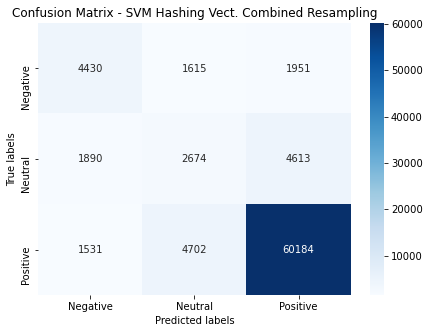

In [11]:
# Support Vector Machine with linear cernel
from sklearn.svm import LinearSVC

# Train the classifier
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(X_comb, y_comb)

predictions_SVM = clf.predict(Test_X_Hashing)

# Get grades by review
predicted_scores_frame = pd.DataFrame(np.column_stack([Test_index, predictions_SVM, Test_Y]), 
                               columns=['review Index', 'prediction', 'actual'])

print(len(predicted_scores_frame['review Index'].unique()) - len(Test_Y_review))

# for each review get all scores by review
scores_by_review_frame = predicted_scores_frame.groupby('review Index')['prediction'].apply(list)

majority_scores =  scores_by_review_frame.apply(find_Max_Element)
predicted_scores = list(majority_scores)

# for each review get its actual score
actual_scores_frame = predicted_scores_frame.groupby('review Index')['actual'].first()
actual_scores = list(actual_scores_frame)

# get all indexes
review_indexes = predicted_scores_frame['review Index'].unique()

# Calculate Accuracy
accuracy = accuracy_score(predicted_scores, actual_scores)*100
print("Accuracy: ", accuracy)
print("-----------------------")

# Confusion Matrix
cm = confusion_matrix(actual_scores, predicted_scores)
plt.figure(figsize = (7,5))
ax = plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',ax=ax)
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - SVM Hashing Vect. Combined Resampling'); 
ax.xaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']); 
ax.yaxis.set_ticklabels(['Negative', 'Neutral', 'Positive']);

# Classification Report
my_tags = ['Negative','Neutral','Positive']
print(classification_report(actual_scores, predicted_scores, target_names=my_tags))
report = classification_report(actual_scores, predicted_scores, target_names=my_tags, output_dict=True);
clsf_report = pd.DataFrame(report).transpose()
clsf_report.to_csv('reports/SVM_HashingVectorizer_CombinedResampling.csv', index= True)

In [12]:
# write indexes of false classified reviews to a txt file
data = {"review_index": review_indexes, "predict": predicted_scores, "actual": actual_scores}

review_dataframe = pd.DataFrame(data)

false_classified_indexes = review_dataframe['review_index'][review_dataframe['predict'] != review_dataframe['actual']]
false_classified_indexes = list(false_classified_indexes)

with open("indexes/SVM_HashingVectorizer_CombinedResampling.txt", 'w') as f:
    for item in false_classified_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as negative but they are neutral
negativePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 0)]
negativePredicted_neutralActual_indexes = list(negativePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_NegativePredicted_NeutralActual.txt", 'w') as f:
    for item in negativePredicted_neutralActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as negative but they are positive
negativePredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == -1) & (review_dataframe['actual'] == 1)]
negativePredicted_positiveActual_indexes = list(negativePredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_NegativePredicted_PositiveActual.txt", 'w') as f:
    for item in negativePredicted_positiveActual_indexes:
        f.write("%s\n" % item)
        
# save those indexes who are predicted as neutral but they are negative
neutralPredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == -1)]
neutralPredicted_negativeActual_indexes = list(neutralPredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_NeutralPredicted_NegativeActual.txt", 'w') as f:
    for item in neutralPredicted_negativeActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as neutral but they are positive
neutralPredicted_positiveActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 0) & (review_dataframe['actual'] == 1)]
neutralPredicted_positiveActual_indexes = list(neutralPredicted_positiveActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_NeutralPredicted_PositiveActual.txt", 'w') as f:
    for item in neutralPredicted_positiveActual_indexes:
        f.write("%s\n" % item)

# save those indexes who are predicted as positive but they are negative        
positivePredicted_negativeActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == -1)]
positivePredicted_negativeActual_indexes = list(positivePredicted_negativeActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_PositivePredicted_NegativeActual.txt", 'w') as f:
    for item in positivePredicted_negativeActual_indexes:
        f.write("%s\n" % item)
 
# save those indexes who are predicted as positive but they are neutral 
positivePredicted_neutralActual_indexes = review_dataframe['review_index'][(review_dataframe['predict'] == 1) & (review_dataframe['actual'] == 0)]
positivePredicted_neutralActual_indexes = list(positivePredicted_neutralActual_indexes)
with open("indexes/SVM_HashingVectorizer_CombinedResampling_PositivePredicted_NeutralActual.txt", 'w') as f:
    for item in positivePredicted_neutralActual_indexes:
        f.write("%s\n" % item)